In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import dowhy
from dowhy import CausalModel
import dowhy.datasets as ds, dowhy.plotter
import econml

Let's load the data saved after feature selction correlation

In [2]:
data = pd.read_csv("../data/df.csv")
data.drop("Unnamed: 0", axis=1, inplace = True)

In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data["diagnosis"] = le.fit_transform(data["diagnosis"])
data["diagnosis"].value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

Let's use Random Forest to see if our feature choice is accurate

Accuracy is:  1.0


<AxesSubplot:>

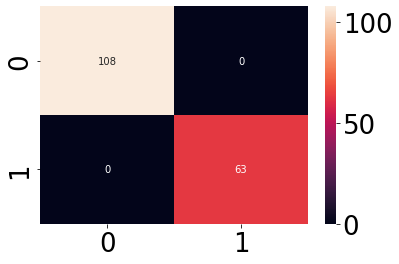

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score

y = data["diagnosis"]
# split data train 70 % and hold_out 30 %
x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=42)

#random forest classifier with n_estimators=10 (default)
clf_rf = RandomForestClassifier(random_state=43)      
clr_rf = clf_rf.fit(x_train,y_train)

ac = accuracy_score(y_test,clf_rf.predict(x_test))
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test,clf_rf.predict(x_test))
sns.heatmap(cm,annot=True,fmt="d")


Well it looks like our feature selection is good we have accuracy of 100%

SPLIT DATA TO TRAIN AND HOLD OUT SET

In [5]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(data, random_state=20, test_size=.2)

In [6]:
train_df.shape

In [7]:
valid_df.shape

DEFINE CAUSAL MODEL

In [10]:
d = ds.linear_dataset(beta=5,
    num_common_causes=5,
    num_instruments = 0,
    num_samples=10000,
    treatment_is_binary=True)

In [11]:
d["dot_graph"] = 'digraph { U[label="Unobserved Confounders"];U->Diagnosis;area_mean->Diagnosis;concavity_mean->Diagnosis;area_se->Diagnosis;symmetry_worst->Diagnosis;concavity_worst->Diagnosis;symmetry_se->Diagnosis;concavity_se->Diagnosis;smoothness_se->Diagnosis;fractal_dimension_mean->Diagnosis;smoothness_mean->Diagnosis;symmetry_se->Diagnosis;fractal_dimension_se->Diagnosis;smoothness_worst->Diagnosis;fractal_dimension_worst->Diagnosis;}'

In [12]:
model = CausalModel(
    data = train_df,
    treatment = ["Diagnosis"],
    outcome = "Diagnosis",
    graph = d["dot_graph"]
)



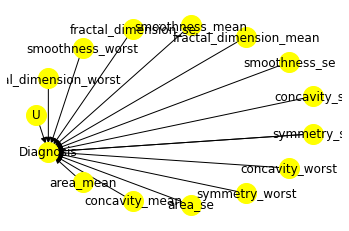

In [13]:
model.view_model()

In [14]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                               
────────────(E[Diagnosis|symmetryₛₑ])
d[Diagnosis]                         
Estimand assumption 1, Unconfoundedness: If U→{Diagnosis} and U→Diagnosis then P(Diagnosis|Diagnosis,symmetry_se,U) = P(Diagnosis|Diagnosis,symmetry_se)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                                            
 ⎢                                                                            
E⎢────────────────────────────────────────────────────────────────────────────
 ⎣d[smoothnessₘₑₐₙ  concavityₘₑₐₙ  smoothness_worst  fractal_dimension_worst  

                                                                              
                        d                                                     
──────────────────────────────────────────────────────────────────────────────
symmetry_worst  fractal_di

CALCULATE CAUSAL EFFECT BASED ON ESTIMAND

In [24]:
d["gml_graph"]

'graph[directed 1node[ id "y" label "y"]node[ id "Unobserved Confounders" label "Unobserved Confounders"]edge[source "Unobserved Confounders" target "y"]node[ id "W0" label "W0"] node[ id "W1" label "W1"] node[ id "W2" label "W2"] node[ id "W3" label "W3"] node[ id "W4" label "W4"]node[ id "v0" label "v0"]edge[source "Unobserved Confounders" target "v0"]edge[source "v0" target "y"]edge[ source "W0" target "v0"] edge[ source "W1" target "v0"] edge[ source "W2" target "v0"] edge[ source "W3" target "v0"] edge[ source "W4" target "v0"]edge[ source "W0" target "y"] edge[ source "W1" target "y"] edge[ source "W2" target "y"] edge[ source "W3" target "y"] edge[ source "W4" target "y"]]'

In [23]:
model = CausalModel(
    data = data,
    treatment = ["Diagnosis"],
    outcome = "Diagnosis",
    graph = d["dot_graph"]
)

In [26]:
ds.linear_dataset(beta=5,
    num_common_causes=5,
    num_instruments = 0,
    num_samples=10000,
    treatment_is_binary=True)

{'df':             W0        W1        W2        W3        W4     v0         y
 0    -0.251997 -0.984549 -1.909862 -1.758111 -1.099024  False -2.521640
 1    -1.080954 -0.994842 -0.844613 -1.562862 -2.003386  False -3.242703
 2    -0.138832 -0.720641 -1.694602 -1.224519 -0.621694  False -1.824603
 3     0.099690  0.240425 -0.010823 -0.627017 -1.077175  False  0.441351
 4    -0.567266  0.262007 -0.789647  0.099728 -0.723973  False -0.227898
 ...        ...       ...       ...       ...       ...    ...       ...
 9995  1.666695  1.423316 -1.000474 -0.348972 -0.795413  False  4.122926
 9996 -0.726016  1.876666 -0.494486  0.473049 -0.037491   True  7.641569
 9997  1.490995  0.943755 -0.924596 -0.034824 -1.336206   True  8.100734
 9998  1.207695 -0.052731  0.248414 -0.140117 -3.222674  False  1.094782
 9999  1.772834  0.480542 -1.892638 -0.933257  0.703355   True  7.411690
 
 [10000 rows x 7 columns],
 'treatment_name': ['v0'],
 'outcome_name': 'y',
 'common_causes_names': ['W0', 'W1', 'W2

In [27]:
data = dowhy.datasets.linear_dataset(
    beta=10,
    num_common_causes=5,
    num_instruments=2,
    num_samples=10000,
    treatment_is_binary=True)


In [30]:
#Create a causal model from the data and given graph.
model = CausalModel(
    data=data["df"],
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    graph=data["gml_graph"])

# Compute causal effect using metalearner
identified_estimand_experiment = model.identify_effect(proceed_when_unidentifiable=True)

from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model.estimate_effect(identified_estimand_experiment,                             method_name="backdoor.econml.metalearners.TLearner",
confidence_intervals=False,
method_params={
     "init_params":{'models': RandomForestRegressor()},
     "fit_params":{}
              })
print(metalearner_estimate)


/home/selam/anaconda3/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W1,W0,W4,W3,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W4,W3,W2,U) = P(y|v0,W1,W0,W4,W3,W2)

## Realized estimand
b: y~v0+W1+W0+W4+W3+W2
Target units: ate

## Estimate
Mean value: 12.377612548392335
Effect estimates: [10.68813794 12.64811098 13.78109529 ... 11.7197977  13.46051978
  9.43494106]



(array([  87., 2574., 3666., 2217., 1001.,  345.,   78.,   21.,    6.,
           5.]),
 array([ 7.70786312,  9.37587525, 11.04388738, 12.71189951, 14.37991164,
        16.04792377, 17.7159359 , 19.38394803, 21.05196016, 22.71997229,
        24.38798442]),
 <BarContainer object of 10 artists>)

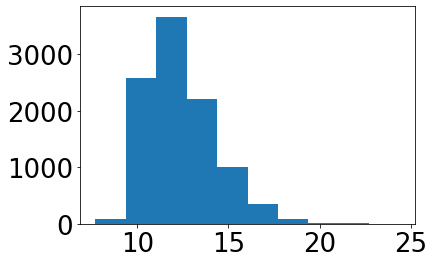

In [32]:
# Print histogram of causal effects
import matplotlib.pyplot as plt
plt.hist(metalearner_estimate.cate_estimates)

Since the causal effect is not Gaussian distributed the mean doesn't represnet the overall disribution.